In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy
import sklearn
from sklearn import cluster
from eofs.standard import Eof
from scipy.cluster.vq import vq

print('libraries loaded')

libraries loaded


In [3]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [4]:

# note this takes around a minute to load in 

dataset = Dataset('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/Data/European_MSLP_and_MSLP_anomaly_data.nc')
ERA5_MSLP_anom  = dataset.variables['MSLP_anom'][:]
lons = dataset.variables['lon'][:]
lats = dataset.variables['lat'][:]
dataset.close()

print(np.shape(ERA5_MSLP_anom))
print(lons)

(42, 365, 149, 229)
[-22.   -21.75 -21.5  -21.25 -21.   -20.75 -20.5  -20.25 -20.   -19.75
 -19.5  -19.25 -19.   -18.75 -18.5  -18.25 -18.   -17.75 -17.5  -17.25
 -17.   -16.75 -16.5  -16.25 -16.   -15.75 -15.5  -15.25 -15.   -14.75
 -14.5  -14.25 -14.   -13.75 -13.5  -13.25 -13.   -12.75 -12.5  -12.25
 -12.   -11.75 -11.5  -11.25 -11.   -10.75 -10.5  -10.25 -10.    -9.75
  -9.5   -9.25  -9.    -8.75  -8.5   -8.25  -8.    -7.75  -7.5   -7.25
  -7.    -6.75  -6.5   -6.25  -6.    -5.75  -5.5   -5.25  -5.    -4.75
  -4.5   -4.25  -4.    -3.75  -3.5   -3.25  -3.    -2.75  -2.5   -2.25
  -2.    -1.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25   0.     0.25
   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25   2.5    2.75
   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75   5.     5.25
   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25   7.5    7.75
   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75  10.    10.25
  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25 

In [5]:
# reshape the MSLP anom into [time,lat*lon]

# take first 38 years. 
# Take Jan-Mar and concatenate  Dec onto the end of it
DJFM_MSLP = np.concatenate((ERA5_MSLP_anom[0:38,0:90,:,:],ERA5_MSLP_anom[0:38,335:365,:,:]),axis=1)
print(np.shape(DJFM_MSLP))

#reshape into 2d array for creation of EOFS in next step
reshaped_MSLP_anom = np.reshape(DJFM_MSLP,(38*120,len(lats)*len(lons)))


print(np.shape(reshaped_MSLP_anom))

(38, 120, 149, 229)
(4560, 34121)


In [6]:
pcNEOFS = np.load('DJFM_cluster_assignment_1979_to_2016_with_30_clusters_v1_accompanying_PCs.npy')

cluster_numbers = np.load('DJFM_cluster_assignment_1979_to_2016_with_30_clusters_v1.npy')

In [7]:
print(np.shape(cluster_numbers))

(4560,)


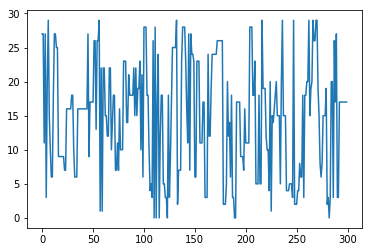

In [8]:
plt.plot(cluster_numbers[0:300])

Text(0, 0.5, 'Number of Occurences')

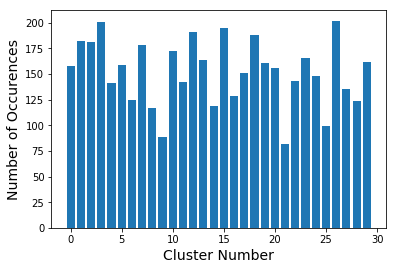

In [9]:
a,b = np.histogram(cluster_numbers,bins=np.linspace(0,30,31))

plt.bar(b[0:len(a)],a)
plt.xlabel('Cluster Number',fontsize=14)
plt.ylabel('Number of Occurences',fontsize=14)



In [10]:

cluster_mean_centroids = np.zeros([30,len(lats),len(lons)])

for clust_i in range(0,30):
    args_list = np.where(cluster_numbers == clust_i)
    #print(args_list)
    #print(np.shape(args_list))
    
    data_we_need = reshaped_MSLP_anom[args_list[0],:]
    data_we_need_reshaped = np.reshape(data_we_need,(len(args_list[0]),len(lats),len(lons)))
    cluster_centroid = np.mean(data_we_need_reshaped,axis=0)
    cluster_mean_centroids[clust_i,:,:] = cluster_centroid

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


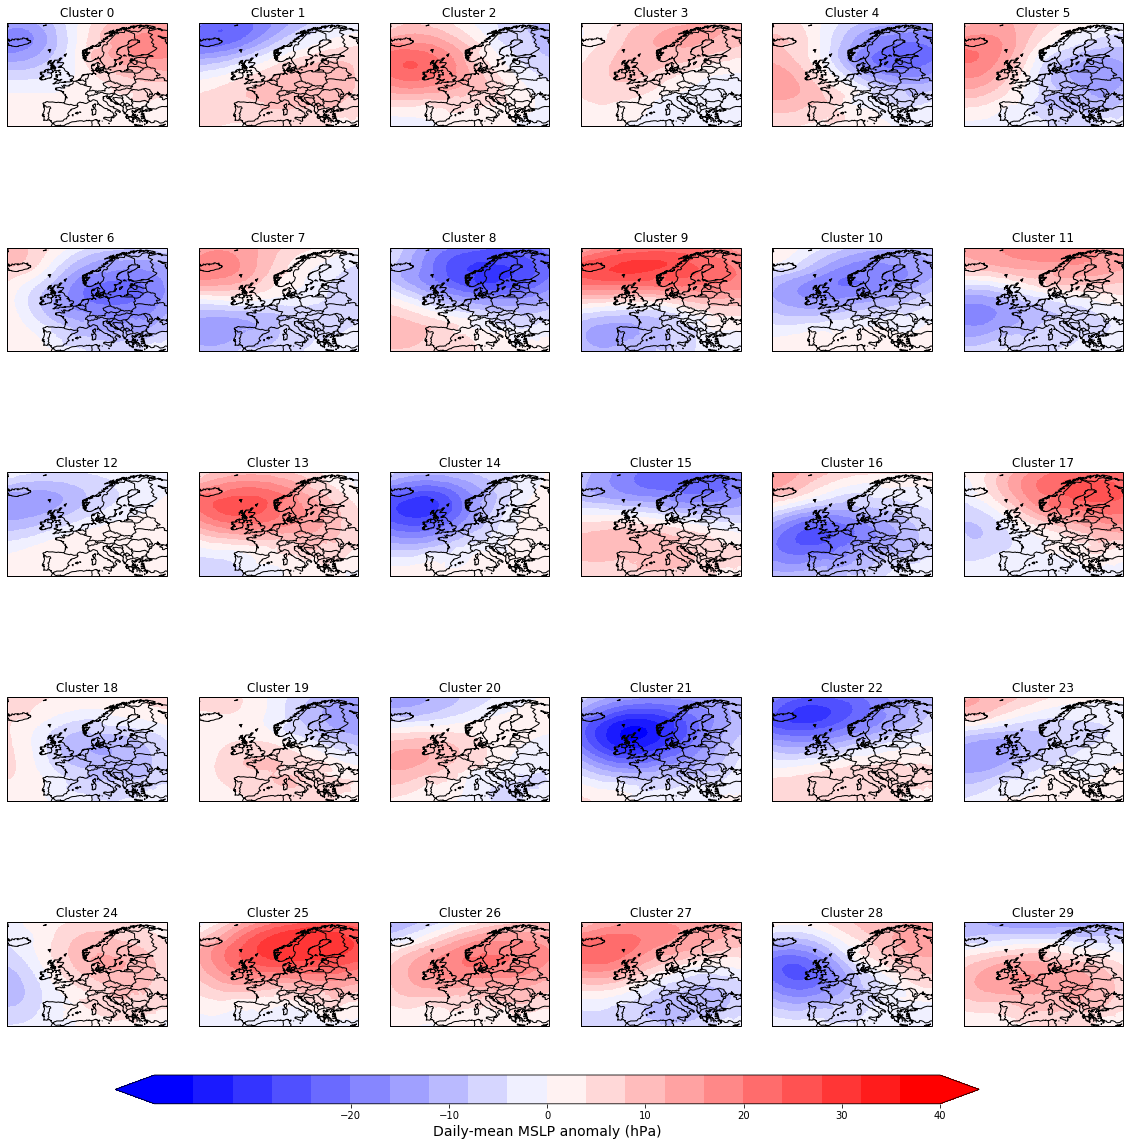

In [35]:
# Spatial plot of the first day of data
gridded_lons,gridded_lats = np.meshgrid(lons,lats)

# setup colorbar
bounds = np.linspace(-40,40,21)
cmap = plt.cm.bwr
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
# setup plot
fig = plt.figure(figsize=(20,20))
for i in range(0,30):
    print(i)
    ax1 = fig.add_subplot(5,6,i+1,projection=ccrs.PlateCarree())
    cs = plt.pcolor(gridded_lons, gridded_lats, cluster_mean_centroids[i,:,:],cmap =cmap,norm=norm,transform=ccrs.PlateCarree())
    plt.title('Cluster ' + str(i),fontsize=12)
    ax1.coastlines(resolution='50m')
    ax1.add_feature(cartopy.feature.BORDERS)
    

ax2 = fig.add_axes([0.2,0.1,0.6,0.02])    
cb = mpl.colorbar.ColorbarBase(ax2,cmap=cmap,norm=norm,orientation='horizontal',extend='both',ticks=[-40.-30,-20,-10,0,10,20,30,40])
cb.set_label('Daily-mean MSLP anomaly (hPa)',fontsize=14)
plt.show()


In [204]:
field = 'speed10m'

ERA5_t2m = np.load('ERA5_UK_' + field + '_hourly_data_1979_2020.npy')

diurnal_t2m = np.reshape(ERA5_t2m,(42,365,24))

In [205]:
DJFM_t2m = np.concatenate((diurnal_t2m[0:38,0:90,:],diurnal_t2m[0:38,335:365,:]),axis=1)
print(np.shape(DJFM_t2m))

reshaped_t2m = np.reshape(DJFM_t2m,(38*120,24))


t2m_analouges = []

for clust_i in range(0,30):
    args_list = np.where(cluster_numbers == clust_i)
    #print(args_list)
    #print(np.shape(args_list))
    
    data_we_need = reshaped_t2m[args_list[0],:]
    #print(np.shape(data_we_need))
    t2m_analouges.append(data_we_need)

(38, 120, 24)


In [206]:
# find median analogue

median_analouge = np.zeros([30,24])

for an_i in range(0,30):
    temp = np.zeros(len(t2m_analouges[an_i]))
    #print(len(temp))
    for j in range(0,len(t2m_analouges[an_i])):
        temp[j] = np.round(np.nansum(t2m_analouges[an_i][j]),2)
        sort_temp = np.sort(temp)
        
        
    #print(sort_temp)
    #print(np.int(np.floor(len(t2m_analouges[an_i])/2)))
    med = sort_temp[np.int(np.floor(len(t2m_analouges[an_i])/2))]
    #print(med)
    #print(np.shape(temp))
    arg_med = np.argwhere(temp == med)[0] #if two match then take the first one
    #print(arg_med)
    #print(t2m_analouges[an_i][arg_med])
    median_analouge[an_i,:] = t2m_analouges[an_i][arg_med]
    
    
#print(np.shape(t2m_analouges[an_i]))
    
    

In [207]:
# calculate the percentiles along these analogues

percentiles = [1,5,10,25,50,75,90,95,99]
percentiles_for_analogues = np.zeros([30,len(percentiles),24])

for an_i in range(0,30):
    for hr_j in range(0,24):
        percentiles_for_analogues[an_i,:,hr_j] = np.nanpercentile(t2m_analouges[an_i][:,hr_j],percentiles)
        
print(percentiles_for_analogues[0,0,:])
        


[2.61657406 2.5362261  2.51738295 2.58192486 2.69581818 2.7747992
 2.79854788 2.74281885 2.74448381 2.8986974  3.0035668  3.10738227
 3.15686582 3.18376754 3.18819792 2.88187405 2.95294074 2.96066401
 3.00169911 3.0057135  2.91062823 2.88788933 2.9682013  2.89267345]


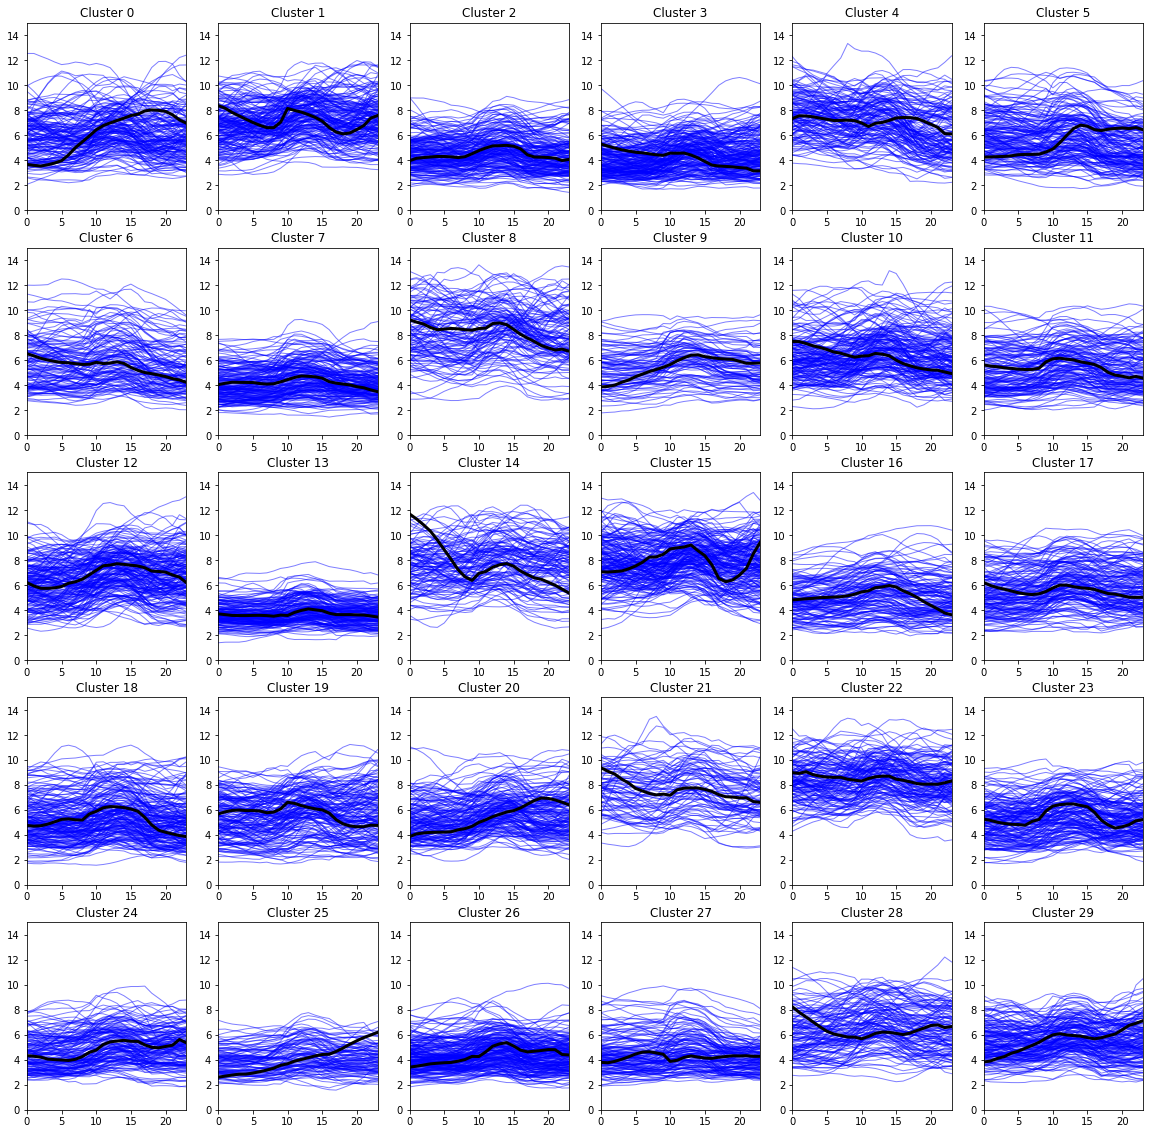

In [208]:
fig = plt.figure(figsize=(20,20))
for i in range(0,30):
    ax1 = fig.add_subplot(5,6,i+1,)
    
    if field == 'speed10m':
        COL = 'blue'
    elif field =='T2m':
        COL = 'red'
    elif field =='ssrd':
        COL = 'gold'
    elif field == 'tp':
        COL = 'teal'
    
    plt.plot(t2m_analouges[i].transpose(),color=COL,alpha=0.5,linewidth=1)
    plt.plot(median_analouge[i,:],color='k',linewidth=3)
    
    plt.xlim([0,23])
    if field == 'ssrd':
        plt.ylim([0,650])
    elif field == 'T2m':
        plt.ylim([-8,20])
    elif field == 'tp':
        plt.ylim([0,0.002])
    elif field =='speed10m':
        plt.ylim([0,15])
    plt.title('Cluster ' + str(i),fontsize=12)
    

plt.show()



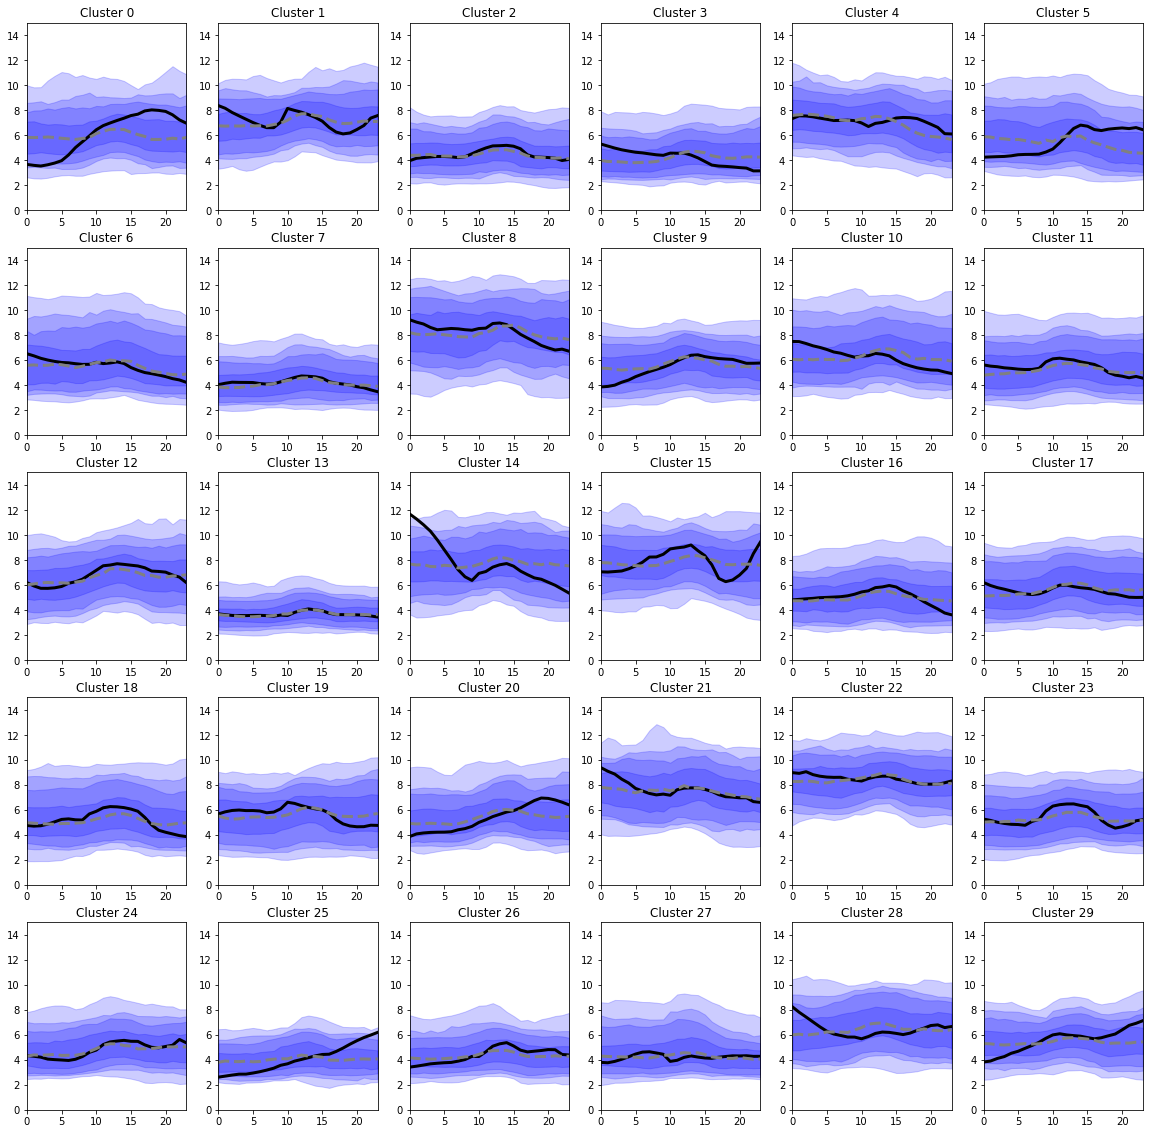

In [209]:
fig = plt.figure(figsize=(20,20))
for i in range(0,30):
    ax1 = fig.add_subplot(5,6,i+1,)
    if field == 'speed10m':
        COL = 'blue'
    elif field =='T2m':
        COL = 'red'
    elif field =='ssrd':
        COL = 'gold'
    elif field == 'tp':
        COL = 'teal'
    plt.fill_between(np.linspace(0,23,24),percentiles_for_analogues[i,3,:].transpose(),percentiles_for_analogues[i,5,:].transpose(),color=COL,alpha=0.2)
    plt.fill_between(np.linspace(0,23,24),percentiles_for_analogues[i,2,:].transpose(),percentiles_for_analogues[i,6,:].transpose(),color=COL,alpha=0.2)
    plt.fill_between(np.linspace(0,23,24),percentiles_for_analogues[i,1,:].transpose(),percentiles_for_analogues[i,7,:].transpose(),color=COL,alpha=0.2)
    plt.fill_between(np.linspace(0,23,24),percentiles_for_analogues[i,0,:].transpose(),percentiles_for_analogues[i,8,:].transpose(),color=COL,alpha=0.2)

    plt.plot(median_analouge[i,:],color='k',linewidth=3)
    plt.plot(percentiles_for_analogues[i,4,:],color='grey',linestyle='--',linewidth=3)
    plt.xlim([0,23])
    if field == 'ssrd':
        plt.ylim([0,650])
    elif field == 'T2m':
        plt.ylim([-8,20])
    elif field == 'tp':
        plt.ylim([0,0.002])
    elif field =='speed10m':
        plt.ylim([0,15])
    plt.title('Cluster ' + str(i),fontsize=12)
    

plt.show()


In [210]:

#save the medians and percentile outputs to get this going for the case studies.

np.save('median_analogue_' + field,median_analouge)
np.save('percentile_distribution_' + field,percentiles_for_analogues)

